In [1]:
import numpy as np
from numpy.random import normal
from scipy.stats import sigmaclip
import matplotlib.pyplot as py

In [2]:
def beck_mag_cuts(uband, gband, rband, iband, zband, coloronly=False, verbose=False):
    '''
    Input:
    uband, gband, rband, iband, zband = 2D numpy arrays containing the (ugriz)-band magnitudes and their errors
        e.g. uband[0] = array of magnitudes
             uband[1] = array of magnitude errors
    coloronly = Make cuts based only on colour and not not errors (useful for debugging)
    verbose = if True, print how many galaxies remain after each cut
    
    Returns:
        An array containing the indexes of galaxies that made the cut
    '''
    
    ugcolor = uband-gband
    grcolor = gband-rband
    ricolor = rband-iband
    izcolor = iband-zband
    
    #Estimate color errors. 
    #This assumes no covariances in errors between different bands
    err_gr = np.sqrt(gband[1]**2 + rband[1]**2)
    err_ri = np.sqrt(rband[1]**2 + iband[1]**2)
    err_iz = np.sqrt(iband[1]**2 + zband[1]**2)
    
    #Cuts on color
    uginds = np.where((ugcolor[0] > -0.911) & (ugcolor[0] < 5.597))[0]
    grinds = np.where((grcolor[0] > 0.167) & (grcolor[0] < 2.483))[0]
    riinds = np.where((ricolor[0] > 0.029) & (ricolor[0] < 1.369))[0]
    izinds = np.where((izcolor[0] > -0.542) & (izcolor[0] < 0.790))[0]

    #Cuts on magnitude error
    drinds = np.where(rband[1] < 0.15)[0]
    dgrinds = np.where(err_gr < 0.225)[0]
    driinds = np.where(err_ri < 0.15)[0]
    driznds = np.where(err_iz < 0.25)[0]

    #Find indexes valid to all conditions
    vi1 = np.intersect1d(uginds, grinds)
    vi2 = np.intersect1d(riinds, izinds)
    valinds = np.intersect1d(vi1, vi2)

    if coloronly == False:
        vi4 = np.intersect1d(drinds, dgrinds)
        vi5 = np.intersect1d(driinds, driznds)
        vi6 = np.intersect1d(vi4, vi5)
        valinds = np.intersect1d(valinds, vi6)
    
    if verbose == False:
        print("Original length: ", len(uband[0]))
        print("Valid (u-g): ", len(uginds))
        print("Valid (g-r): ", len(grinds))
        print("Valid (r-i): ", len(riinds))
        print("Valid (i-z): ", len(izinds))
        
        if coloronly == False:
            print("Valid d(r): ", len(drinds))
            print("Valid d(g-r): ", len(dgrinds))
            print("Valid d(r-i): ", len(driinds))
            print("Valid d(i-z): ", len(driznds))

        print("All valid: ", len(valinds))
        
    return valinds

In [3]:
#Estimate errors from the data itself
        
def estimate_photo_err(myband, bins, doplot=False, mag2plot=20):
    '''
    From a set of input photometric magnitudes, it will estimate the errors assuming Gaussian statistics.
    The median and clipped std dev are used to determine Gaussian properties. 
    One can choose to plot the real errors and estimated errors together.
    
    Input:
    myband = one of the five SDSS photometric bands
    bins = an array that defines the binning
    doplot = if True, plot the true errors from "myband" and estimated errors
    
    Returns:
       Array of estimated errors for each input magnitude
       Array of measured median and clipped std. dev. for each mag. bin
    '''
    
    nbins = len(bins)
    ngal = len(myband[0])
    
    #Initialize some arrays
    std_mag = np.zeros(nbins)
    med_mag = np.zeros(nbins)
    myerr = np.zeros(ngal)
    
    #Bin the magnitudes. The statistics will be calculated in each bin.
    digi = np.digitize(myband[0], bins)

    #Loop over bins
    for bb in range(nbins):
        #Pull out galaxies that are in the current bin of interest
        blah = np.where(digi==bb)[0]
        
        #Median
        med_mag[bb] = np.median(myband[1][blah])
        
        #Clipped stddev (this removes outliers)
        ss,sl,sh=sigmaclip(myband[1][blah])
        std_mag[bb] = np.std(ss)

        #Simulate Gaussian noise
        mynoise = normal(med_mag[bb], std_mag[bb], size=(len(blah),))

        #Put these back into the full array
        myerr[blah] = mynoise

    if doplot:
        imag = np.where(bins >= mag2plot)[0][0]
        mymag = np.where(digi == imag)[0]
        lmag = len(mymag)
        
        py.figure()
        py.hist(myband[1,mymag], bins=100)
        py.hist(normal(med_mag[imag], std_mag[imag], size=(lmag,)), histtype='step', 
                label='Med = %f\nStd = %f' % (med_mag[imag], std_mag[imag]), bins=100)
        py.legend()
        py.title("m = %f" % mag2plot)
        
    return myerr, med_mag, std_mag
    

In [4]:
#Read in actual SDSS magnitudes from the online database
# Note, all of this desperately should be re-written as a class
sdss=np.loadtxt('Skyserver_SQL1_25_2021 1_32_23 PM.csv', unpack=True, delimiter=',')

ngal = sdss.shape[1]

MU,U_MU=0,1  #u-band magnitude
MG,U_MG=2,3 #g-band magnitude
MR,U_MR=4,5  #r-band magnitude
MI,U_MI=6,7  #i-band magnitude
MZ,U_MZ=8,9  #z-band magnitude

#Pull out magnitude data
uband=sdss[MU:U_MU+1]
gband=sdss[MG:U_MG+1]
rband=sdss[MR:U_MR+1]
iband=sdss[MI:U_MI+1]
zband=sdss[MZ:U_MZ+1]

ugcolor = uband-gband
grcolor = gband-rband
ricolor = rband-iband
izcolor = iband-zband
    
grcolor[1] = np.sqrt(gband[1]**2 + rband[1]**2)
ricolor[1] = np.sqrt(rband[1]**2 + iband[1]**2)
izcolor[1] = np.sqrt(iband[1]**2 + zband[1]**2)

In [7]:
#Estimate errors from the data itself
#Define edges of magnitude bins
bins=np.arange(13,30,0.5)
nbins=len(bins)

#Estimate the photo errors from data and add the new errors to the existing arrays
#  The array for each band now has dimensions 3 x N where
#  Row 0 = photometry; 1 = real photo errors; 2 = est. photo errors
uerr,umed,ustd=estimate_photo_err(uband, bins)
uband = np.vstack((uband, uerr))
gerr,gmed,gstd=estimate_photo_err(gband, bins)
gband = np.vstack((gband, gerr))
rerr,rmed,rstd=estimate_photo_err(rband, bins)
rband = np.vstack((rband, rerr))
ierr,imed,istd=estimate_photo_err(iband, bins)
iband = np.vstack((iband, ierr))
zerr,zmed,zstd=estimate_photo_err(zband, bins)
zband = np.vstack((zband, zerr))

#Calc colors
ugcolor = uband-gband
grcolor = gband-rband
ricolor = rband-iband
izcolor = iband-zband

#Est. errors on colors using real errors (assuming independence)
grcolor[1] = np.sqrt(gband[1]**2 + rband[1]**2)
ricolor[1] = np.sqrt(rband[1]**2 + iband[1]**2)
izcolor[1] = np.sqrt(iband[1]**2 + zband[1]**2)

#Est. errors on colors using est. errors (assuming independence)
grcolor[2] = np.sqrt(gband[2]**2 + rband[2]**2)
ricolor[2] = np.sqrt(rband[2]**2 + iband[2]**2)
izcolor[2] = np.sqrt(iband[2]**2 + zband[2]**2)



In [10]:
#Apply the SDSS magnitude cut?
apply_mag_cut=False

u_max = 22.15
g_max = 23.13
r_max = 22.70
i_max = 22.20
z_max = 20.71

#Median 5-sigma depths
#https://www.sdss.org/dr14/imaging/other_info/
if apply_mag_cut:
    imax=np.where(uband[0]<=u_max)[0]
    uband=uband[:,imax]
    
    imax=np.where(gband[0]<=g_max)[0]
    gband=gband[:,imax]
    
    imax=np.where(rband[0]<=r_max)[0]
    rband=rband[:,imax]
    
    imax=np.where(iband[0]<=i_max)[0]
    iband=iband[:,imax]
    
    imax=np.where(zband[0]<=z_max)[0]
    zband=zband[:,imax]


#Deterine which galaxies pass the Beck cuts assuming the real and est errors
vinds_real=beck_mag_cuts(uband[[0,1]], gband[[0,1]], rband[[0,1]], iband[[0,1]], zband[[0,1]], coloronly=False)
vinds_est=beck_mag_cuts(uband[[0,2]], gband[[0,2]], rband[[0,2]], iband[[0,2]], zband[[0,2]], coloronly=False)

uband_real=uband[:,vinds_real]
gband_real=gband[:,vinds_real]
rband_real=rband[:,vinds_real]
iband_real=iband[:,vinds_real]
zband_real=zband[:,vinds_real]

uband_est=uband[:,vinds_est]
gband_est=gband[:,vinds_est]
rband_est=rband[:,vinds_est]
iband_est=iband[:,vinds_est]
zband_est=zband[:,vinds_est]

Original length:  20000
Valid (u-g):  19518
Valid (g-r):  19079
Valid (r-i):  17126
Valid (i-z):  16691
Valid d(r):  15220
Valid d(g-r):  11706
Valid d(r-i):  10406
Valid d(i-z):  9111
All valid:  7180
Original length:  20000
Valid (u-g):  19518
Valid (g-r):  19079
Valid (r-i):  17126
Valid (i-z):  16691
Valid d(r):  15528
Valid d(g-r):  12246
Valid d(r-i):  10655
Valid d(i-z):  9457
All valid:  7131


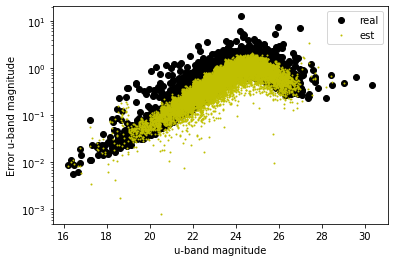

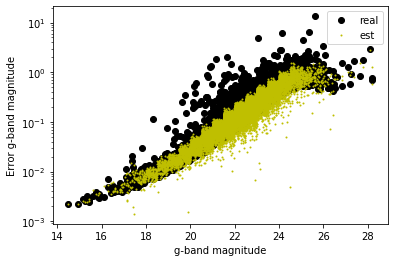

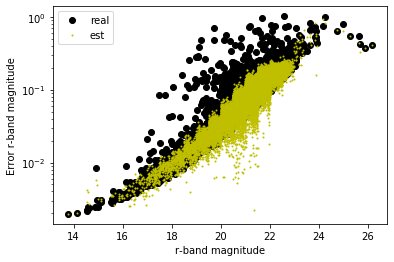

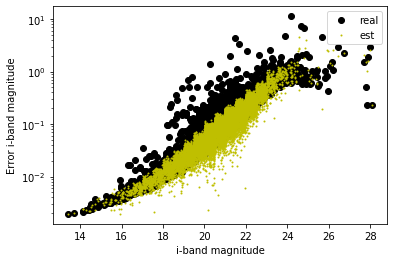

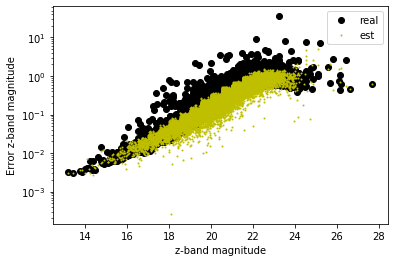

In [11]:
#Plot photometry and errors
bandnames = ['u-band', 'g-band', 'r-band', 'i-band', 'z-band']
allbands = [uband, gband, rband, iband, zband]
all_est = [uband_est, gband_est, rband_est, iband_est, zband_est]
all_real = [uband_real, gband_real, rband_real, iband_real, zband_real]

for ii in range(len(allbands)):
    py.figure()
    py.plot(allbands[ii][0], allbands[ii][1], ls='', marker='o', color='k', label='real')
    py.plot(allbands[ii][0], allbands[ii][2], ls='', marker='o', color='y', ms=1, label='est')
    
    #py.plot(all_est[ii][0], all_est[ii][2], ls='', marker='+', color='y', ms=10, label='cut est')
    #py.plot(all_real[ii][0], all_real[ii][1], ls='', marker='o', color='r', ms=2, label='cut real')
    
    py.legend()
    py.yscale('log')
    py.xlabel('%s magnitude' % bandnames[ii])
    py.ylabel('Error %s magnitude' % bandnames[ii])

Text(0, 0.5, 'ri color error')

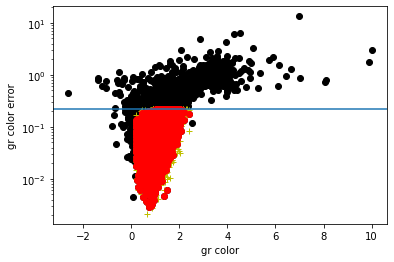

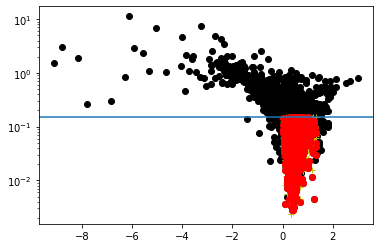

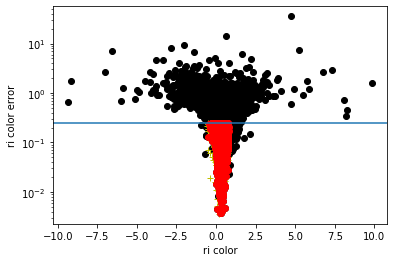

In [11]:
#Plot colors and errors
py.figure()
py.plot(grcolor[0], grcolor[1], 'ko')
py.plot(grcolor[0,vinds_est], grcolor[2,vinds_est], 'y+')
py.plot(grcolor[0,vinds_real], grcolor[1,vinds_real], 'ro')
py.axhline(0.225)
py.yscale('log')

py.xlabel('gr color')
py.ylabel('gr color error')

py.figure()
py.plot(ricolor[0], ricolor[1], 'ko')
py.plot(ricolor[0,vinds_est], ricolor[2,vinds_est], 'y+')
py.plot(ricolor[0,vinds_real], ricolor[1,vinds_real], 'ro')
py.axhline(0.15)
py.yscale('log')

py.figure()
py.plot(izcolor[0], izcolor[1], 'ko')
py.plot(izcolor[0,vinds_est], izcolor[2,vinds_est], 'y+')
py.plot(izcolor[0,vinds_real], izcolor[1,vinds_real], 'ro')
py.axhline(0.25)
py.yscale('log')

py.xlabel('ri color')
py.ylabel('ri color error')

(0, 0.2)

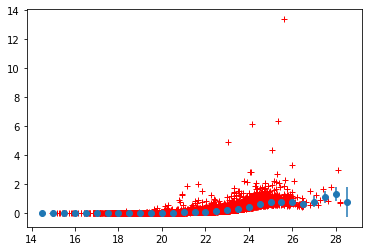

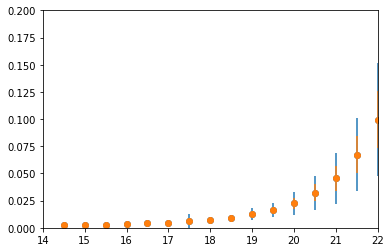

In [15]:
#Compare estimated statistics with true scatter in the data
myband = gband
merr,med_mag,std_mag=estimate_photo_err(myband, bins, doplot=False, mag2plot=20)

#This plot doesn't make sense. Rethink
#py.plot(myband[0], myband[1], 'r+')
#py.errorbar(bins, med_mag, yerr=std_mag, fmt='o')
#py.xlabel('magnitude bin')
#py.ylabel('median error')

py.figure()
py.errorbar(bins, med_mag, yerr=2*std_mag, fmt='o')
py.errorbar(bins, med_mag, yerr=std_mag, fmt='o')
py.axhline(0.15, color='k')
py.xlabel('magnitude')
py.xlim((14,22))
py.ylim((0,0.2))